In [5]:
from urllib.request import urlopen
import os
import pandas as pd
from IPython.display import Video
from mexca.video.extraction import FaceExtractor
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt

In [3]:
video = FaceExtractor(
        au_model = 'JAANET',
        landmark_model='PFLD',
        min_clusters = 2,
        max_clusters = 2
    )

In [4]:
filepath = "2_speaker_total.mp4"

Store embeddings and mexca output

In [5]:
out, emb = video.apply(filepath.strip())

606it [04:09,  2.43it/s]                         


Puts nan (no faces frames) to zero

In [15]:
embs =  np.asarray(emb)
embs[np.isnan(embs)]=0 

Define MDS ojbect as mds and `fit_transform` the embeddings: returns 2dimensional version of the embeddings

In [24]:
mds = MDS(n_components=2,random_state=0)

embs_2d = mds.fit_transform(embs)

embs_2d will have shape equals to number of frames by 2 dimensions

In [117]:
embs_2d.shape

(807, 2)

Plot 2d embeddings coloured by label

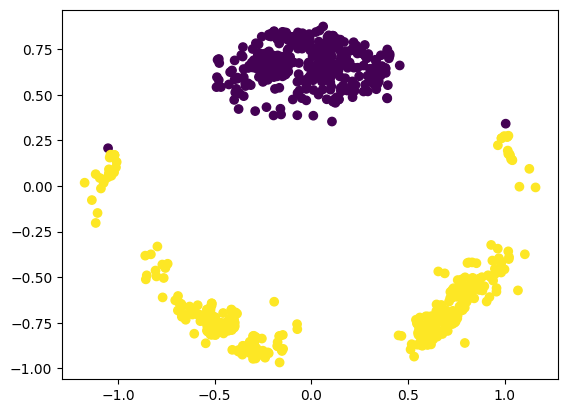

In [25]:
plt.scatter(embs_2d[:,0],embs_2d[:,1],c=out['face_id'])

# Compute distance from centroid

In [42]:
# store labels
labels = np.asarray(out['face_id'])

# initialise vector
centroids = []
for label in np.unique(labels):
    # subset embeddings related to label
    label_embs = embs[labels==label]
    # compute centroid as average of the subsetted embeddings
    centroid = np.nanmean(label_embs,axis=0)
    if not np.isnan(label):
        # append to centroids
        centroids.append(centroid)


# Compute distances from each labels centroids

In [120]:
distances = []

for centroid in centroids:
    # cosine distance from all embeddings and each labels' centroid 
    D = cosine_distances(embs,centroid.reshape(-1, 1).T)
    distances.append(D)

distances = np.asarray(distances)
print(distances.shape)

(2, 807, 1)


Compute and plot embeddings coloured by distance from first centroid

In [122]:
# compute cosine distance among all pair of points/embeddings
D = cosine_distances(embs,embs)
# shape will be equals to number of frames by n of frames
print(D.shape)

# compute MDS using precomputed distance matrix D
mds = MDS(n_components=2,random_state=0,dissimilarity='precomputed')
embs_2d = mds.fit_transform(D)

(807, 807)


Plot distances in respect to the first label

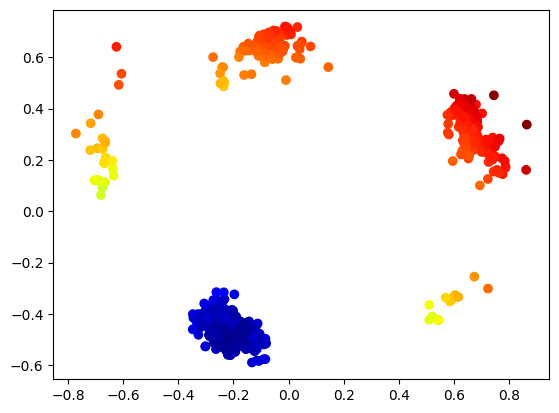

In [123]:
plt.scatter(embs_2d[:,0],embs_2d[:,1],c=distances[0],cmap=plt.cm.jet)

other label

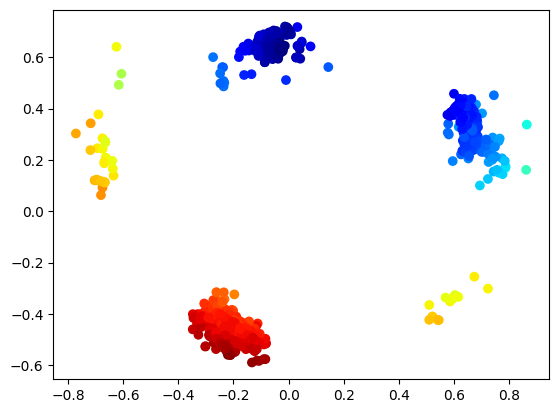

In [54]:
plt.scatter(embs_2d[:,0],embs_2d[:,1],c=distances[1],cmap=plt.cm.jet)

histogram of distances from first label

<AxesSubplot: ylabel='Count'>

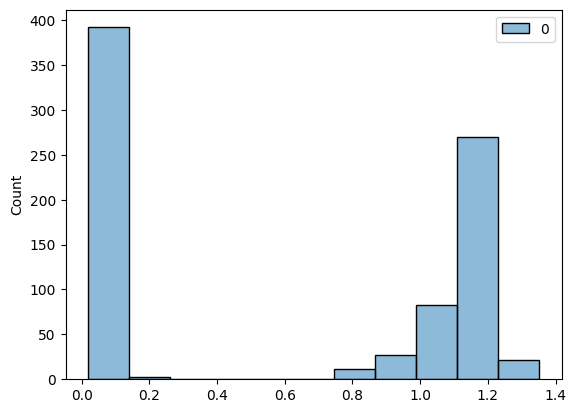

In [52]:
sns.histplot(distances[0])

second label

<AxesSubplot: ylabel='Count'>

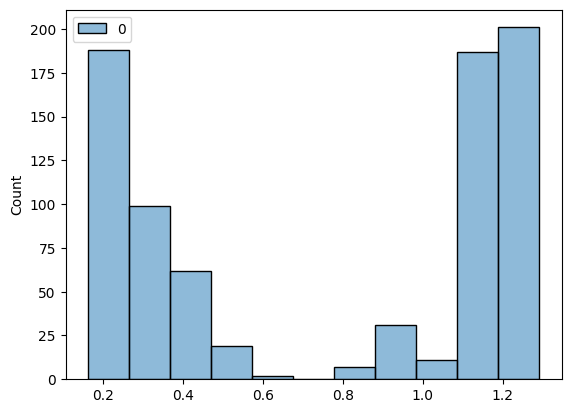

In [55]:
sns.histplot(distances[1])

histogram of distances of all points pairs

<AxesSubplot: ylabel='Count'>

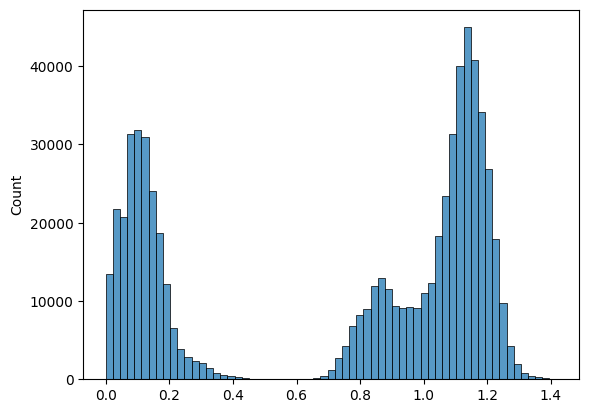

In [56]:
sns.histplot(D.flatten())

Function for computing label's confidence

In [112]:
def compute_confidence(embeddings,labels):
    # compute unique cluster labels
    unique_labels = np.unique(labels)
    # get rid of nan label
    unique_labels = unique_labels[np.logical_not(np.isnan(unique_labels))]

    # compute centroids:
    centroids = [] # list of centroid
    cluster_label_mapping = {} # maps the cluster label to the intex of the centroid list
 
    for i,label in enumerate(unique_labels):
        # extract embeddings that have given label
        label_embeddings = embeddings[labels==label]
        # compute centroid of label_emeddings (vector mean)
        centroid = np.nanmean(label_embeddings,axis=0)
        # appends do centroid list
        centroids.append(centroid)
        cluster_label_mapping[label] = i

    # create empty array with same lenght as labels. 
    confidence = np.empty_like(labels)
    
    # cycle over frames
    for i,(frame_embedding,label) in enumerate(zip(embeddings,labels)):
        #if frame is unclassified, assigns zero confidence
        if np.isnan(label):
            confidence[i] = np.nan

        else:
            # compute distance between frame embedding and each centroid
            # frame embedding is put in list becouse it is required by cosine distances API
            # cosine distances returns a list of list, so [0] is taken to get correct shape
            distances = cosine_distances([frame_embedding],centroids)[0]

            cluster_centroid_idx = cluster_label_mapping[label] # recover index of centroid of cluster 

            # distance to the centroid of the cluster to which the frame belongs
            
            d1 = distances[cluster_centroid_idx]
            # mimimum of all other distance
            d2 = np.min(distances[np.arange(len(distances))!=cluster_centroid_idx])
            
            #confidence score: 0 if d1=d2, 1 if d1 = 0
            c = (d2-d1)/d2
            
            # handle edge case: in principle d1<d2 by definition, but if the clustering that produced
            # the labels used a different distance definition, this could not be the case. This
            # edge cases are low confidence.
            if c<0:
                c = 0

            confidence[i] = c
    
    return confidence
    
    

In [113]:
confidences = compute_confidence(embs,labels)

In [125]:
confidences.shape

(807,)

In [114]:
# Plot condifdences
mds = MDS(n_components=2,random_state=0)
embs_2d = mds.fit_transform(embs)

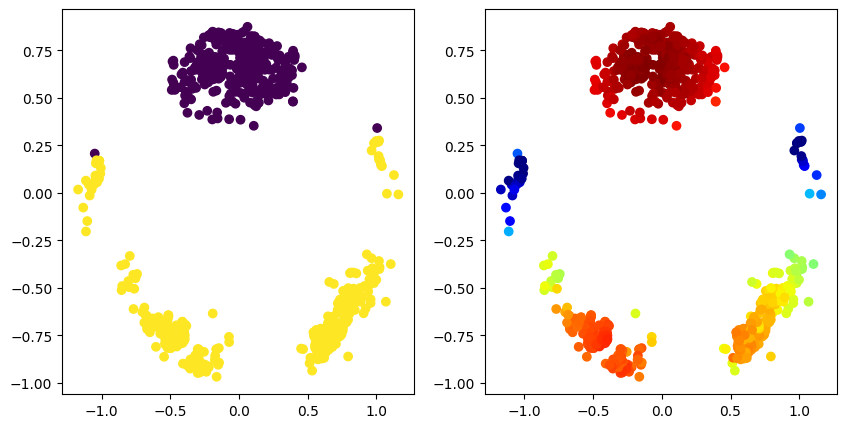

In [115]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(embs_2d[:,0],embs_2d[:,1],c=labels)

plt.subplot(1,2,2)
plt.scatter(embs_2d[:,0],embs_2d[:,1],c=confidences,cmap=plt.cm.jet)

<AxesSubplot: ylabel='Count'>

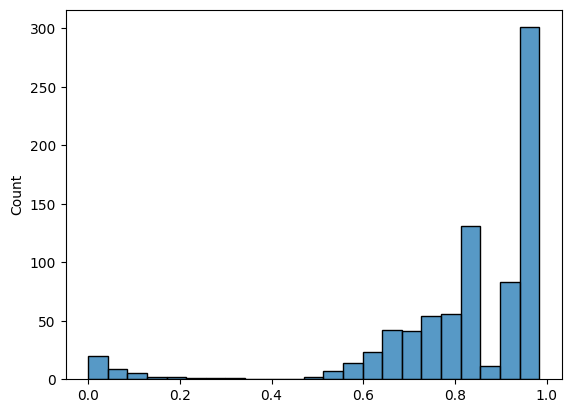

In [116]:
sns.histplot(confidences)